In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import ot
# from ot.bregman import (barycenter, barycenter_debiased,
#                         convolutional_barycenter2d,
#                         convolutional_barycenter2d_debiased)
from tqdm.notebook import tqdm

import torch
from scipy.linalg import sqrtm
# from Barycenter_fixed import barycenter_debiased_1d

In [3]:
def grad_d_loss(bar, K, d, reg):
    return reg*torch.mv(K, d) - reg*(bar/d)

def barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-5, weights=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    P = torch.as_tensor(P).clone().detach().to(device)
    M = torch.as_tensor(M).clone().detach().to(device)
    
    dim, n_hists = P.shape
    
    K = torch.exp(-M / reg)
    eta = 1e-10
    K = K + eta * torch.eye(K.shape[0], device=device)

    Ka = torch.ones_like(P, device=device)
    Kb = torch.ones_like(P, device=device)
    
    b = torch.ones_like(P, device=device)

    d, bar = torch.ones((2, dim), dtype=P.dtype, device=device)
    
    err_d = 0.0
    hist_err_d = []
    err_bar = 0.0
    hist_err_bar = []
    hist_norm_grad_d = []

    if weights is None:
        weights = torch.ones(n_hists, dtype=P.dtype, device=device) / n_hists
    else:
        assert len(weights) == P.shape[1]
        
    for ii in tqdm(range(maxiter)):
        bar_old = bar.clone()
        a = P / Kb
        Ka = K.t().mm(a)
        bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
        b = bar[:, None] / Ka
        Kb = K.mm(b)

        d_old = d
        d = (d * bar / K.mv(d)) ** 0.5
        grad_d = grad_d_loss(bar, K, d, reg)
        norm_grad_d = torch.linalg.norm(grad_d).item()

        err_bar = abs(bar - bar_old).max().item()
        if ii > 1:
            hist_err_bar.append(err_bar)
            hist_norm_grad_d.append(norm_grad_d)

        if err_bar < tol and norm_grad_d < tol and ii > 10:
            break

    return bar, hist_err_bar, hist_norm_grad_d


In [4]:
def gen1D_gaussian(x, m, s):
    p = (1/(np.sqrt(2*np.pi*s**2))) * np.exp(-(x-m)**2 / (2*s**2))
    return p

In [5]:
n_features = 100


m1 = 10
s1 = 2.5
m2 = 90
s2 = 2.5

grid = np.linspace(0,100,n_features)


# Gaussian distributions
p1 = gen1D_gaussian(grid, m1, s1)  # m= mean, s= std
p2 = gen1D_gaussian(grid, m2, s2)


# creating matrix A containing all distributions
P = np.vstack((p1, p2)).T
n_distributions = P.shape[1]

# loss matrix + normalization
M = (grid[:, None] - grid[None, :])**2
M = M / M.max()

# 1. Check the convergence

In [6]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([0.5, 5, 50, 500]) / n_features
# epsilons = [0.005, 0.05, 0.1, 0.5]

bars_debiased = []
hists_err_bar = []
hists_norm_grad_d = []
for reg in epsilons:
    print("Doing original updating...")
    bar_debiased, hist_err_bar, hist_norm_grad_d = barycenter_debiased_1d(P, M, reg, maxiter=10000, tol=1e-6, weights=None)
    bars_debiased.append(bar_debiased)
    hists_err_bar.append(hist_err_bar)
    hists_norm_grad_d.append(hist_norm_grad_d)
#     list_K.append(K)
    # print("Doing new updating with GD...")
    # bar_debiased_gd, hist_err_bar_gd, hist_err_d_gd = barycenter_debiased_1d_gd(P, M, reg, maxiter=5000, tol=1e-6, lr=0.995, weights=None)
    # bars_debiased_gd.append(bar_debiased_gd)

Doing original updating...


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
bar_expected = gen1D_gaussian(grid, m=50, s=2.5)

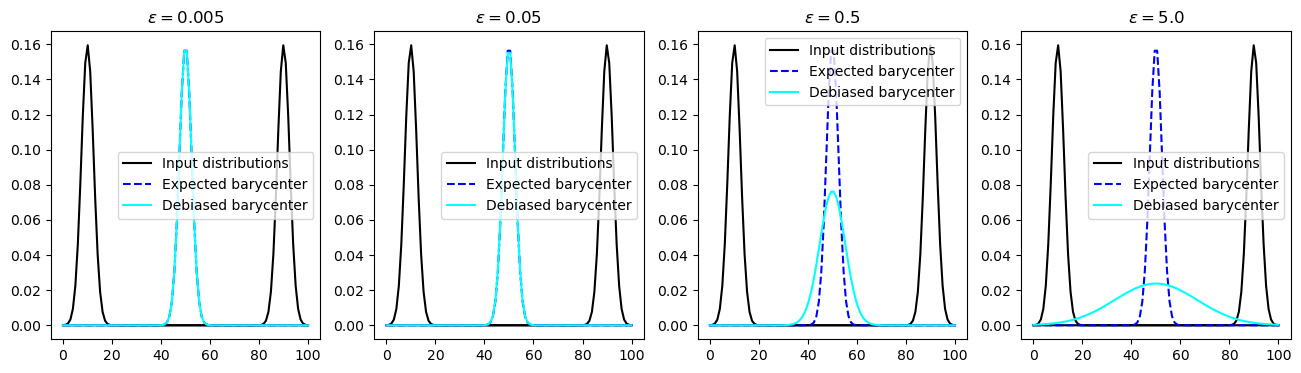

In [8]:
fig,axs = plt.subplots(1,4, figsize = (16,4))

for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    axs[i].plot(grid, bar_expected, color ='blue', linestyle='dashed', label='Expected barycenter')
    # axs[i].plot(grid, bars_debiased_gd[i], color = 'purple', label="New updating using GD")
    axs[i].plot(grid, bars_debiased[i], color='cyan', label='Debiased barycenter')
    axs[i].legend()
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
plt.show()

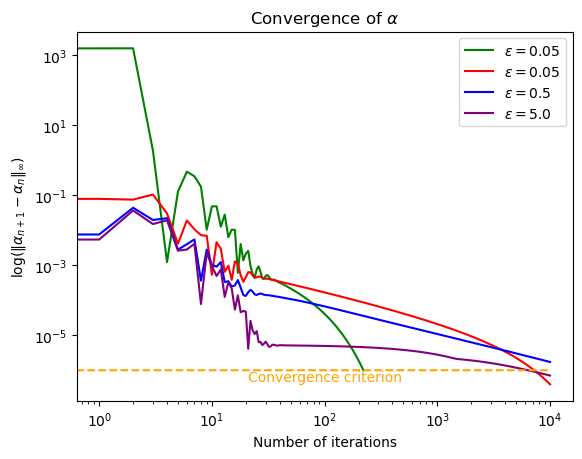

In [13]:
# plt.plot(np.arange(20, 20+ len(hists_err_bar[1])*10, step=10),hists_err_bar[1],label='$\\varepsilon = {}$'.format(epsilons[1]),color='red')
# plt.plot(np.arange(20, 20+ len(hists_err_bar[2])*10, step=10), hists_err_bar[2],label='$\\varepsilon = {}$'.format(epsilons[2]),color='blue')
# plt.plot(np.arange(20, 20+ len(hists_err_bar[3])*10, step=10),hists_err_bar[3],label='$\\varepsilon = {}$'.format(epsilons[3]),color = 'purple')

plt.plot(hists_err_bar[0],label='$\\varepsilon = {}$'.format(epsilons[1]),color='green')
plt.plot(hists_err_bar[1],label='$\\varepsilon = {}$'.format(epsilons[1]),color='red')
plt.plot(hists_err_bar[2],label='$\\varepsilon = {}$'.format(epsilons[2]),color='blue')
plt.plot(hists_err_bar[3],label='$\\varepsilon = {}$'.format(epsilons[3]),color = 'purple')
plt.plot(np.arange(1e4 + 1), 1e-6*np.ones(10001), linestyle='--',color='orange')
plt.text(100, 1e-6, 'Convergence criterion', verticalalignment='top', horizontalalignment='center', color='orange')

plt.xlabel('Number of iterations')
plt.ylabel('$\log(\Vert \\alpha_{n+1} - \\alpha_n \Vert_{\infty})$')
plt.xscale('log')
plt.yscale('log')
plt.title('Convergence of $\\alpha$')
plt.legend()
plt.show()

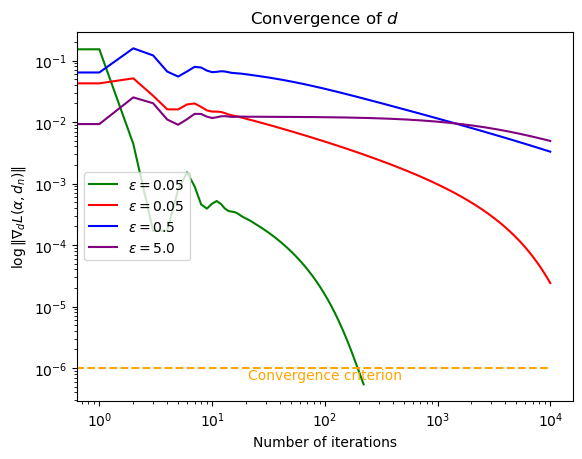

In [14]:
# plt.plot(np.arange(20, 20+ len(hists_err_d[1])*10, step=10),hists_err_d[1],label='$\\varepsilon = {}$'.format(epsilons[1]),color='red')
# plt.plot(np.arange(20, 20+ len(hists_err_d[2])*10, step=10), hists_err_d[2],label='$\\varepsilon = {}$'.format(epsilons[2]),color='blue')
# plt.plot(np.arange(20, 20+ len(hists_err_d[3])*10, step=10),hists_err_d[3],label='$\\varepsilon = {}$'.format(epsilons[3]),color = 'purple')

plt.plot(hists_norm_grad_d[0],label='$\\varepsilon = {}$'.format(epsilons[1]),color='green')
plt.plot(hists_norm_grad_d[1],label='$\\varepsilon = {}$'.format(epsilons[1]),color='red')
plt.plot(hists_norm_grad_d[2],label='$\\varepsilon = {}$'.format(epsilons[2]),color='blue')
plt.plot(hists_norm_grad_d[3],label='$\\varepsilon = {}$'.format(epsilons[3]),color = 'purple')
plt.plot(np.arange(1e4 + 1), 1e-6*np.ones(10001), linestyle='--',color='orange')
plt.text(100, 1e-6, 'Convergence criterion', verticalalignment='top', horizontalalignment='center', color='orange')

plt.xlabel('Number of iterations')
plt.ylabel('$\log\Vert\\nabla_d L(\\alpha,d_n)\Vert$')
plt.xscale('log')
plt.yscale('log')
plt.title('Convergence of $d$')
plt.legend()
plt.show()

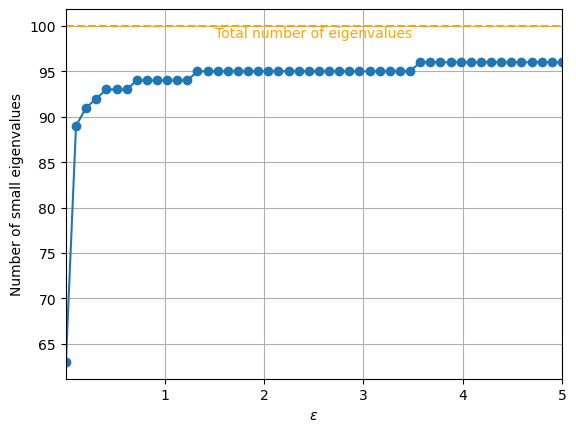

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define epsilon values
# epsilons = np.array([0.005, 0.05, 0.5])
eps = np.linspace(start=epsilons[0],stop=epsilons[-1],num=50)
# epsilons = np.geomspace(start=0.05,stop=0.5,num=20)



# List to store the count of small eigenvalues for each epsilon
small_eigenvalues_count = []

# Define the threshold for small eigenvalues
threshold = 1e-5

# Compute K, eigenvalues, and count small eigenvalues
for epsilon in eps:
    K = np.exp(-M / epsilon)
    eigenvalues, _ = np.linalg.eig(K)
    small_eigenvalues = np.sum(np.abs(eigenvalues) < threshold)
    small_eigenvalues_count.append(small_eigenvalues)

# Plotting
plt.plot(eps, small_eigenvalues_count, marker='o')
plt.plot(eps, np.full_like(eps,100), linestyle='dashed', color='orange')
plt.xlabel('$\\varepsilon$')
plt.ylabel('Number of small eigenvalues')
plt.xlim([0.005,5])
plt.grid()
plt.text(2.5, 100, 'Total number of eigenvalues', verticalalignment='top', horizontalalignment='center', color='orange')
plt.show()


# 2. Using Projected Gradient Descent

In [28]:
import torch
import numpy as np

def grad_d_loss(bar, K, d, reg):
    return reg*torch.mv(K, d) - reg*(bar/d)


def barycenter_debiased_1d_pgd(P, M, reg, maxiter=5000, tol=1e-6, lr=0.1, weights=None, accelerated = True):
    """Compute the Wasserstein divergence barycenter between histograms."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    P = torch.as_tensor(P).clone().detach().to(device)
    M = torch.as_tensor(M).clone().detach().to(device)
    
    dim, n_hists = P.shape
    
    K = torch.exp(-M / reg)
    eta = 1e-10
    K = K + eta * torch.eye(K.shape[0], device=device)

    Ka = torch.ones_like(P, device=P.device)
    Kb = torch.ones_like(P, device=P.device)
    
    b = torch.ones_like(P, device=P.device)

    d, bar = torch.ones((2, dim), dtype=P.dtype, device=P.device)
    
    err_d = 0.0
    hist_err_d = []
    
    re_err_bar = 0.0
    err_bar = 0.0
    
    hist_err_bar = []
    hist_d = []

    if weights is None:
        weights = torch.ones(n_hists, dtype=P.dtype, device=P.device) / n_hists
    else:
        assert len(weights) == P.shape[1]
    
    d_tild = torch.ones_like(d, device = device)

    y = d.clone()  # FISTA momentum variable
    t = 1.0       # FISTA momentum term

    for ii in tqdm(range(maxiter)):
        bar_old = bar.clone()
        a = P / Kb
        Ka = K.t().mm(a)
        bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
        b = bar[:, None] / Ka
        Kb = K.mm(b)

        if accelerated == False:
            # Using ISTA to update d
            d_old = d
            grad = grad_d_loss(bar, K, d,reg)
            d_tild = d - lr*grad
            d = torch.maximum(d_tild, torch.tensor(1e-10))
        else:
            # Using FISTA to update d
            d_old = d
            grad_y = grad_d_loss(bar,K, y,reg)
            d = torch.maximum(y - lr*grad_y, torch.tensor(1e-10))

            t_old = t
            t = (1 + np.sqrt(1 + 4 * t ** 2))/2
            
            y = d + ((t_old - 1) / t) * (d - d_old)
        
        

        err_d = torch.abs(d - d_old).max()
        err_bar = torch.abs(bar - bar_old).max()
        re_err_bar = torch.linalg.norm(bar - bar_old)/(1 + torch.linalg.norm(bar) + torch.linalg.norm(bar_old))


        if ii > 10 and ii % 10 == 0:
            hist_err_d.append(err_d.item())
            hist_err_bar.append(err_bar.item())
            hist_d.append(d)
        if err_bar < tol and ii > 10:
            break

    return bar, hist_err_bar, hist_err_d

In [9]:
# import torch
# import numpy as np

# def grad_d_loss(bar, K, d):
#     return torch.mv(K, d) - (bar/d)

# def barycenter_debiased_1d_Ada(P, M, reg, maxiter=5000, tol=1e-6, lr=0.1, weights=None):
#     """Compute the Wasserstein divergence barycenter between histograms."""
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     P = torch.as_tensor(P).clone().detach().to(device)
#     M = torch.as_tensor(M).clone().detach().to(device)
    
#     dim, n_hists = P.shape
    
#     K = torch.exp(-M / reg)
#     eta = 1e-10
#     K = K + eta * torch.eye(K.shape[0], device=device)

#     Ka = torch.ones_like(P, device=P.device)
#     Kb = torch.ones_like(P, device=P.device)
    
#     b = torch.ones_like(P, device=P.device)

#     d, bar = torch.ones((2, dim), dtype=P.dtype, device=P.device)
    
#     err_d = 0.0
#     hist_err_d = []

#     re_err_bar = 0.0
#     err_bar = 0.0

#     hist_err_bar = []
#     hist_d = []
    
#     if weights is None:
#         weights = torch.ones(n_hists, dtype=P.dtype, device=P.device) / n_hists
#     else:
#         assert len(weights) == P.shape[1]
        
#     grad_accum = torch.zeros_like(d, device=device)  # Accumulated gradient for Adagrad
#     d_tild = torch.ones_like(d, device=device) 

#     for ii in tqdm(range(maxiter)):
#         bar_old = bar.clone()
#         a = P / Kb
#         Ka = K.t().mm(a)
#         bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
#         b = bar[:, None] / Ka
#         Kb = K.mm(b)

#         d_old = d
#         grad = grad_d_loss(bar, K, d)

#         # d = d - lr*grad

#         # Using ADAgrad to update d

#         grad_accum += grad ** 2
#         adjusted_lr = lr / (torch.sqrt(grad_accum) + 1e-8)  # Adagrad update

#         d = d - adjusted_lr * grad

#         err_d = torch.abs(d - d_old).max()
#         err_bar = torch.abs(bar - bar_old).max()
#         re_err_bar = torch.linalg.norm(bar - bar_old)/(1 + torch.linalg.norm(bar) + torch.linalg.norm(bar_old))

#         if ii > 10 and ii % 10 == 0:
#             hist_err_d.append(err_d.item())
#             hist_err_bar.append(re_err_bar.item())
#             hist_d.append(d)
#         if re_err_bar < tol and ii > 10:
#             break

#     return bar, hist_err_bar, hist_err_d

In [253]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([0.5, 5, 50, 500]) / n_features

bars_debiased = []
hists_err_bar = []
hists_err_d = []

bars_debiased_pgd = []
hists_err_bar_pgd = []
hists_err_d_pgd = []
list_lr = [0.03, 0.025, 0.003, 0.0005]

for (reg,lr) in zip(epsilons,list_lr):
    print("Doing original updating...")
    bar_debiased, hist_err_bar, hist_err_d = barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-6, weights=None)
    bars_debiased.append(bar_debiased)
    hists_err_bar.append(hist_err_bar)
    hists_err_d.append(hist_err_d)
    print("Doing new updating with PGD...")
    bar_debiased_pgd, hist_err_bar_pgd, hist_err_d_pgd = barycenter_debiased_1d_pgd(P, M, reg, maxiter=5000, tol=1e-6, lr=lr, weights=None, accelerated=True)
    bars_debiased_pgd.append(bar_debiased_pgd)


Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with PGD...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with PGD...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with PGD...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with PGD...


  0%|          | 0/5000 [00:00<?, ?it/s]

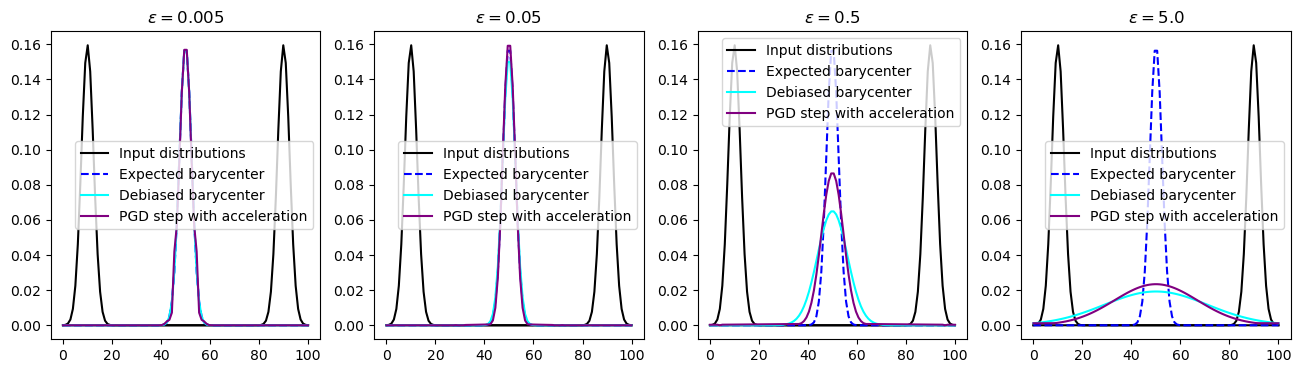

In [255]:
fig,axs = plt.subplots(1,4, figsize = (16,4))
bar_expected = gen1D_gaussian(grid, m=50, s=2.5)
for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    axs[i].plot(grid, bar_expected, color ='blue', linestyle='dashed', label='Expected barycenter')
    axs[i].plot(grid, bars_debiased[i], color='cyan', label='Debiased barycenter')
    axs[i].plot(grid, bars_debiased_pgd[i], color = 'purple', label="PGD step with acceleration")

    axs[i].legend()
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
plt.show()

# 3. Using Proximal gradient with the quadratic term

In [169]:
def prox_quad(v, K, lr):
    ones_tensor = torch.ones(K.shape[0], device=K.device, dtype=K.dtype)
    b = -K.mv(ones_tensor)
    prox = torch.inverse(torch.eye(K.shape[0]) + lr*K).mv(v - lr*b)
    return prox

def grad_KL_d(d,bar,K):
    ones_tensor = torch.ones(K.shape[0], device=K.device, dtype=K.dtype)
    grad_KL_d = -bar/d + K.t().mv(ones_tensor)
    return grad_KL_d

def barycenter_debiased_1d_PG(P, M, reg, rho=1.0, tau=1.5, maxiter=5000, tol=1e-6, lr=0.1, weights=None):
    """Compute the Wasserstein divergence barycenter between histograms.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    P = torch.as_tensor(P).clone().detach().to(device)
    M = torch.as_tensor(M).clone().detach().to(device)
    
    dim, n_hists = P.shape
    
    
    K = torch.exp(-M/reg)
    eta = 1e-10
    K = K + eta*np.eye(K.shape[0])

    Ka = torch.ones_like(P, device=P.device)
    Kb = torch.ones_like(P, device=P.device)
    
    b = torch.ones_like(P, device=P.device)

    d, bar = torch.ones((2, dim), dtype=P.dtype, device=P.device)
    
    
    # err_d = 0.0
    # hist_err_d = []
    err_bar = 0.0
    # hist_err_bar = []

    d_old = d.clone()

    if weights is None:
        weights = torch.ones(n_hists, dtype=P.dtype, device=P.device) / n_hists
    else:
        assert (len(weights) == P.shape[1])
        
    for ii in tqdm(range(maxiter)):
        bar_old = bar.clone()
        a = P / Kb
        Ka = K.t().mm(a)
        bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
        b = bar[:,None] / Ka
        Kb = K.mm(b)


        # Updating d using proximal gradient descent
        d_old = d
        direction = lr*grad_KL_d(d ,bar, K) + rho*torch.maximum(-d,torch.zeros_like(d))
        d = prox_quad(d - direction, K ,lr)
        rho = min(tau*rho,10)

        err_d = abs(d-d_old).max()
        # hist_err_d.append(err_d)

        err_bar = abs(bar-bar_old).max()
        # hist_err_bar.append(err_bar)
        if err_bar < tol and ii > 10:
            break
    # if ii == maxiter - 1:
    #     warnings.warn("*** Maxiter reached ! err = {} ***".format(err))
    return bar

In [170]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([5, 50, 500]) / n_features

bars_debiased = []
hists_err_bar = []
hists_err_d = []

bars_debiased_PG = []

list_lr = [0.1, 0.08, 0.06]
for reg,lr in zip(epsilons,list_lr):
    # print("Doing original updating...")
    # bar_debiased, hist_err_bar, hist_err_d = barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-6, weights=None)
    # bars_debiased.append(bar_debiased)
    print("Doing PGA...")
    bar_debiased_PG = barycenter_debiased_1d_PG(P, M, reg, rho = 1.0, tau =1.5, maxiter=5000, tol=1e-6, lr=lr, weights=None)
    bars_debiased_PG.append(bar_debiased_PG)

Doing PGA...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing PGA...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing PGA...


  0%|          | 0/5000 [00:00<?, ?it/s]

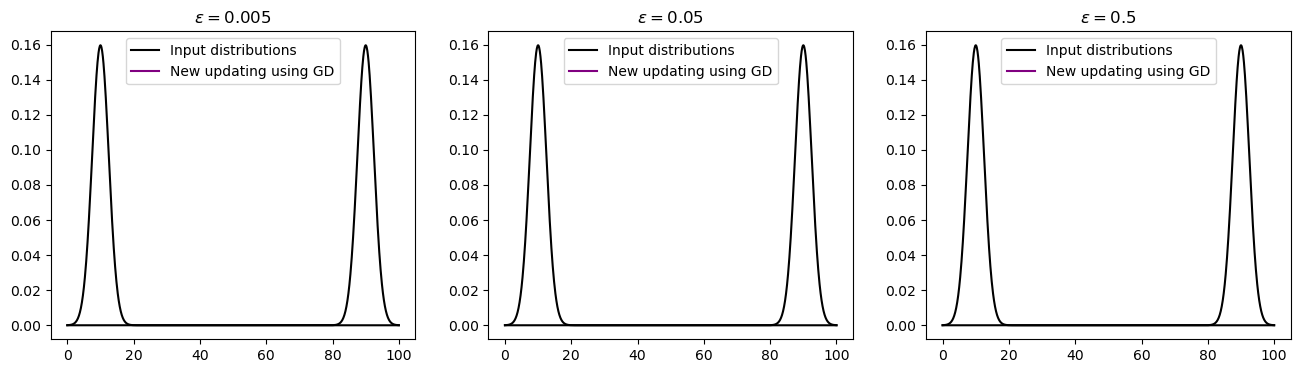

In [175]:
fig,axs = plt.subplots(1,3, figsize = (16,4))

for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    # axs[i].plot(grid, bar_expected, color ='blue', linestyle='dashed', label='Expected barycenter')
    # axs[i].plot(grid, bars_debiased[i], color='cyan', label='Debiased barycenter')
    axs[i].plot(grid, bars_debiased_PG[i], color = 'purple', label="New updating using GD")

    axs[i].legend()
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
plt.show()

# 4. Penalty method

In [80]:
import torch
import numpy as np

def grad_d_loss(bar, K, d, rho):
    term1 = reg*torch.mv(K, d) - reg*bar/(d+1e-10)
    term2 = rho * torch.maximum(-d, torch.zeros_like(d, device = d.device))
    return term1 + term2

def barycenter_debiased_1d_penalty(P, M, reg, maxiter=5000, rho = 0.8, tau =1.5, tol=1e-6, lr=0.1, weights=None):
    """Compute the Wasserstein divergence barycenter between histograms."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    P = torch.as_tensor(P).clone().detach().to(device)
    M = torch.as_tensor(M).clone().detach().to(device)
    
    dim, n_hists = P.shape
    
    K = torch.exp(-M / reg)
    eta = 1e-10
    K = K + eta * torch.eye(K.shape[0], device=device)

    Ka = torch.ones_like(P, device=P.device)
    Kb = torch.ones_like(P, device=P.device)
    
    b = torch.ones_like(P, device=P.device)

    d, bar = torch.ones((2, dim), dtype=P.dtype, device=P.device)
    
    err_d = 0.0
    hist_err_d = []
    
    re_err_bar = 0.0
    err_bar = 0.0
    
    hist_err_bar = []
    hist_d = []

    if weights is None:
        weights = torch.ones(n_hists, dtype=P.dtype, device=P.device) / n_hists
    else:
        assert len(weights) == P.shape[1]
    
    d_tild = torch.ones_like(d, device = device)

    for ii in tqdm(range(maxiter)):
        bar_old = bar.clone()
        a = P / Kb
        Ka = K.t().mm(a)
        bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
        b = bar[:, None] / Ka
        Kb = K.mm(b)


        # Updating d using penalty approach
        d_old = d
        grad = grad_d_loss(bar, K, d, rho)
        d = d - lr*grad
        rho = min(tau * rho, 10 )  # Cap rho at max_rho


        err_d = torch.abs(d - d_old).max()
        err_bar = torch.abs(bar - bar_old).max()
        re_err_bar = torch.linalg.norm(bar - bar_old)/(1 + torch.linalg.norm(bar) + torch.linalg.norm(bar_old))


        if ii > 10 and ii % 10 == 0:
            hist_err_d.append(err_d.item())
            hist_err_bar.append(err_bar.item())
            hist_d.append(d)
        if err_bar < tol and ii > 10:
            break

    return bar, hist_err_bar, hist_err_d

In [83]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([5, 50, 500]) / n_features

bars_debiased = []
hists_err_bar = []
hists_err_d = []

bars_debiased_penalty = []
hists_err_bar_penalty = []
hists_err_d_penalty = []
list_lr = [0.08, 0.05, 0.025]

for (reg,lr) in zip(epsilons,list_lr):
    print("Doing original updating...")
    bar_debiased, hist_err_bar, hist_err_d = barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-6, weights=None)
    bars_debiased.append(bar_debiased)
    hists_err_bar.append(hist_err_bar)
    hists_err_d.append(hist_err_d)
    print("Doing new updating with penalty...")
    bar_debiased_penalty, hists_err_bar_penalty, hists_err_d_penalty = barycenter_debiased_1d_penalty(P, M, reg, maxiter=5000, rho = 1.0, tau =1.5, tol=1e-6, lr=lr, weights=None)
    bars_debiased_penalty.append(bar_debiased_penalty)


Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with penalty...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with penalty...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new updating with penalty...


  0%|          | 0/5000 [00:00<?, ?it/s]

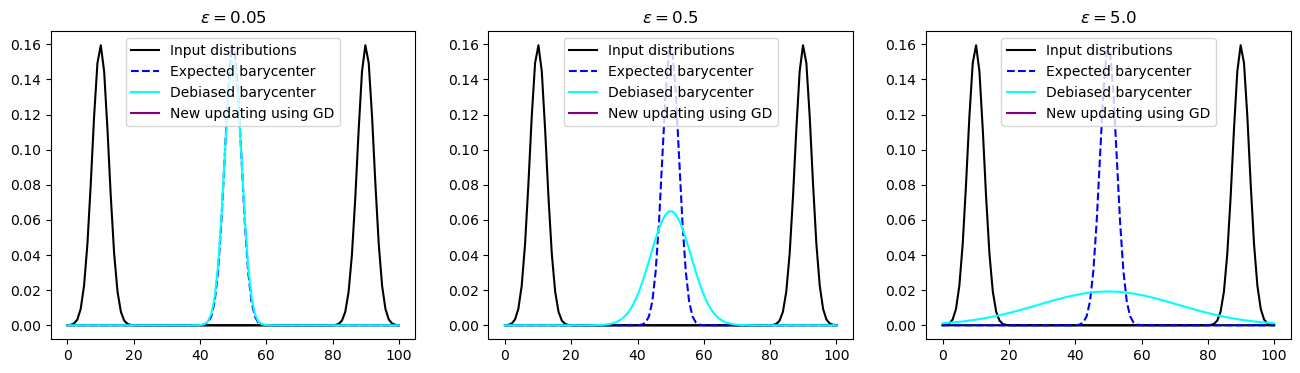

In [84]:
fig,axs = plt.subplots(1,3, figsize = (16,4))
bar_expected = gen1D_gaussian(grid, m=50, s=2.5)
for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    axs[i].plot(grid, bar_expected, color ='blue', linestyle='dashed', label='Expected barycenter')
    axs[i].plot(grid, bars_debiased[i], color='cyan', label='Debiased barycenter')
    axs[i].plot(grid, bars_debiased_penalty[i], color = 'purple', label="New updating using GD")

    axs[i].legend()
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
plt.show()

# 5. Change variable

In [5]:
import torch

def sqrtm(matrix):
    """
    Compute the square root of a semi-positive definite matrix.

    Parameters:
    matrix (torch.Tensor): A semi-positive definite matrix.

    Returns:
    torch.Tensor: The square root of the matrix.
    """
    # Ensure the matrix is square
    assert matrix.shape[0] == matrix.shape[1], "Matrix must be square"

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    eigenvalues = eigenvalues.real  # Since eigenvalues may have small imaginary parts
    eigenvectors = eigenvectors.real
    
    # Ensure all eigenvalues are non-negative (since matrix is semi-positive definite)
    assert torch.all(eigenvalues >= 0), "Matrix must be semi-positive definite"

    # Compute the square root of the eigenvalues
    sqrt_eigenvalues = torch.sqrt(eigenvalues)
    
    # Reconstruct the square root matrix
    sqrtm_matrix = (eigenvectors * sqrt_eigenvalues) @ eigenvectors.T
    
    return sqrtm_matrix

def grad_v_loss(bar, K, K_inv_sqrt, v, reg):
    grad = reg * v
    coeff_term_1 = -bar/(K_inv_sqrt.mv(v) + torch.ones_like(v, device=K.device)) + K.t().mv(torch.ones_like(v,device=K.device))
    for j in range(len(bar)):
        grad = grad + reg * coeff_term_1[j] * K_inv_sqrt[j, :]
    return grad

def barycenter_debiased_1d_new(P, M, reg, maxiter=5000, tol=1e-5, lr=0.1, weights=None):
    """Compute the Wasserstein divergence barycenter between histograms."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    P = torch.as_tensor(P).clone().detach().to(device)
    M = torch.as_tensor(M).clone().detach().to(device)
    
    dim, n_hists = P.shape
    
    K = torch.exp(-M / reg)
    eta = 1e-10
    K = K + eta * torch.eye(K.shape[0], device=K.device)
    
    K_sqrt = sqrtm(K)
    K_inv = torch.linalg.inv(K)
    K_inv_sqrt = sqrtm(K_inv)

    Ka = torch.ones_like(P, device=P.device)
    Kb = torch.ones_like(P, device=P.device)
    
    b = torch.ones_like(P, device=P.device)

    d, bar = torch.ones((2, dim), dtype=P.dtype, device=P.device)

    v = K_sqrt.mv(d - 1)
    
    err_d = 0.0
    hist_err_d = []
    err_bar = 0.0
    hist_err_bar = []

    if weights is None:
        weights = torch.ones(n_hists, dtype=P.dtype, device=P.device) / n_hists
    else:
        assert len(weights) == P.shape[1]
        
    for ii in tqdm(range(maxiter)):
        bar_old = bar.clone()
        a = P / Kb
        Ka = K.t().mm(a)
        bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
        b = bar[:, None] / Ka
        Kb = K.mm(b)

        d_old = d

        grad_v = grad_v_loss(bar, K, K_inv_sqrt, v, reg)
        v_old = v
        v = v - lr * grad_v
        
        d = K_inv_sqrt.mv(v) + torch.ones_like(v, device=device)

        # err_d = abs(d - d_old).max()
        # err_v = abs(v-v_old).max()
        err_bar = abs(bar - bar_old).max()

        hist_err_d.append(err_d)
        hist_err_bar.append(err_bar)
        if err_bar < tol and ii > 10:
            break

    return bar


In [11]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([0.5, 5, 50, 500]) / n_features

bars_debiased = []
hists_err_bar = []
hists_err_d = []

bars_debiased_new = []
list_lr = [0.007, 0.0008, 0.0006, 0.0004]

for (reg,lr) in zip(epsilons,list_lr):
    print("Doing original updating...")
    bar_debiased, hist_err_bar, hist_err_d = barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-6, weights=None)
    bars_debiased.append(bar_debiased)
    hists_err_bar.append(hist_err_bar)
    hists_err_d.append(hist_err_d)
    print("Doing new approach using changing variable...")
    bar_debiased_new = barycenter_debiased_1d_new(P, M, reg, maxiter=5000, tol=1e-6, lr=lr, weights=None)
    bars_debiased_new.append(bar_debiased_new)


Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new approach using changing variable...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new approach using changing variable...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new approach using changing variable...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing original updating...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new approach using changing variable...


  0%|          | 0/5000 [00:00<?, ?it/s]

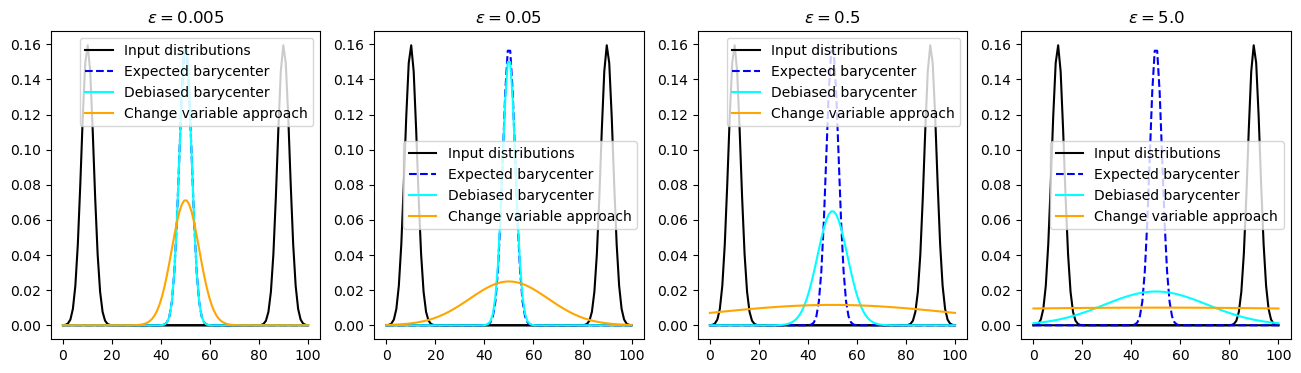

In [13]:
fig,axs = plt.subplots(1,4, figsize = (16,4))
bar_expected = gen1D_gaussian(grid, m=50, s=2.5)
for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    axs[i].plot(grid, bar_expected, color ='blue', linestyle='dashed', label='Expected barycenter')
    axs[i].plot(grid, bars_debiased[i], color='cyan', label='Debiased barycenter')
    axs[i].plot(grid, bars_debiased_new[i], color = 'orange', label="Change variable approach")

    axs[i].legend()
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
plt.show()

## Applying proximal step

In [204]:
import torch

def sqrtm(matrix):
    """
    Compute the square root of a semi-positive definite matrix.

    Parameters:
    matrix (torch.Tensor): A semi-positive definite matrix.

    Returns:
    torch.Tensor: The square root of the matrix.
    """
    # Ensure the matrix is square
    assert matrix.shape[0] == matrix.shape[1], "Matrix must be square"

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    eigenvalues = eigenvalues.real  # Since eigenvalues may have small imaginary parts
    eigenvectors = eigenvectors.real
    
    # Ensure all eigenvalues are non-negative (since matrix is semi-positive definite)
    assert torch.all(eigenvalues >= 0), "Matrix must be semi-positive definite"

    # Compute the square root of the eigenvalues
    sqrt_eigenvalues = torch.sqrt(eigenvalues)
    
    # Reconstruct the square root matrix
    sqrtm_matrix = (eigenvectors * sqrt_eigenvalues) @ eigenvectors.T
    
    return sqrtm_matrix

def prox_l2(v,lr):
    norm_v = torch.linalg.norm(v)
    if norm_v >= lr:
        prox = (1 - lr/norm_v)*v
    else:
        prox = 1e-10*torch.ones_like(v)
    return prox

def grad_v_KL(bar, K, K_inv_sqrt, v, reg):
    grad = torch.zeros_like(v)
    coeff_term_1 = -bar/(K_inv_sqrt.mv(v) + torch.ones_like(v, device=K.device)) + K.t().mv(torch.ones_like(v,device=K.device))
    for j in range(len(bar)):
        grad = grad + reg * coeff_term_1[j] * K_inv_sqrt[j, :]
    return grad

def barycenter_debiased_1d_new1(P, M, reg, maxiter=5000, tol=1e-5, lr=0.1, weights=None):
    """Compute the Wasserstein divergence barycenter between histograms."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    P = torch.as_tensor(P).clone().detach().to(device)
    M = torch.as_tensor(M).clone().detach().to(device)
    
    dim, n_hists = P.shape
    
    K = torch.exp(-M / reg)
    eta = 1e-10
    K = K + eta * torch.eye(K.shape[0], device=K.device)
    
    K_sqrt = sqrtm(K)
    K_inv = torch.linalg.inv(K)
    K_inv_sqrt = sqrtm(K_inv)

    Ka = torch.ones_like(P, device=P.device)
    Kb = torch.ones_like(P, device=P.device)
    
    b = torch.ones_like(P, device=P.device)

    d, bar = torch.ones((2, dim), dtype=P.dtype, device=P.device)

    v = K_sqrt.mv(d - 1)
    y = v.clone()  # FISTA momentum variable
    t = 1.0       # FISTA momentum term

    
    err_d = 0.0
    hist_err_d = []
    err_bar = 0.0
    hist_err_bar = []

    if weights is None:
        weights = torch.ones(n_hists, dtype=P.dtype, device=P.device) / n_hists
    else:
        assert len(weights) == P.shape[1]
        
    for ii in tqdm(range(maxiter)):
        bar_old = bar.clone()
        a = P / Kb
        Ka = K.t().mm(a)
        bar = d * torch.prod((Ka) ** weights[None, :], dim=1)
        
        b = bar[:, None] / Ka
        Kb = K.mm(b)

        d_old = d
        
        # Updating v using ISTA
        v_old = v
        grad_y = grad_v_KL(bar, K, K_inv_sqrt, y, reg)
        v = prox_l2(y - lr*grad_y, lr)
        
        t_old = t
        t = (1 + np.sqrt(1 + 4 * t ** 2))/2

        y = v + ((t_old - 1) / t) * (v - v_old)
        

        # v = prox_l2(v - lr*grad_v, lr)
        

        # Return back 
        d = K_inv_sqrt.mv(v) + torch.ones_like(v, device=device)

        err_d = abs(d - d_old).max()
        err_v = abs(v-v_old).max()
        err_bar = abs(bar - bar_old).max()

        hist_err_d.append(err_d)
        hist_err_bar.append(err_bar)
        if err_bar < tol and ii > 10:
            break

    return bar


In [219]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([0.5, 5, 50, 500]) / n_features

bars_debiased = []
hists_err_bar = []
hists_err_d = []

bars_debiased_new1 = []
list_lr = [0.1, 0.00001, 0.0006, 0.0004]

for (reg,lr) in zip(epsilons,list_lr):
    # print("Doing original updating...")
    # bar_debiased, hist_err_bar, hist_err_d = barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-6, weights=None)
    # bars_debiased.append(bar_debiased)
    # hists_err_bar.append(hist_err_bar)
    # hists_err_d.append(hist_err_d)
    print("Doing new approach using changing variable...")
    bar_debiased_new1 = barycenter_debiased_1d_new1(P, M, reg, maxiter=5000, tol=1e-6, lr=lr, weights=None)
    bars_debiased_new1.append(bar_debiased_new1)


Doing new approach using changing variable...


  0%|          | 0/5000 [00:00<?, ?it/s]

Doing new approach using changing variable...


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

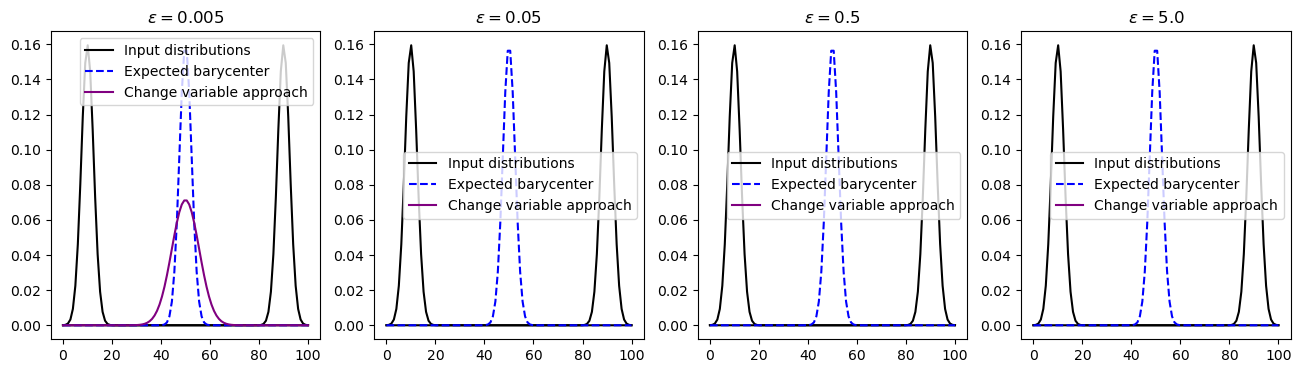

In [ ]:
fig,axs = plt.subplots(1,4, figsize = (16,4))
bar_expected = gen1D_gaussian(grid, m=50, s=2.5)
for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    axs[i].plot(grid, bar_expected, color ='blue', linestyle='dashed', label='Expected barycenter')
    # axs[i].plot(grid, bars_debiased[i], color='cyan', label='Debiased barycenter')
    axs[i].plot(grid, bars_debiased_new1[i], color = 'purple', label="Change variable approach")

    axs[i].legend()
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
plt.show()